# COMP0087 Group 32 Project Source Code: Multiway Attention + DRCN for Textual Entailment


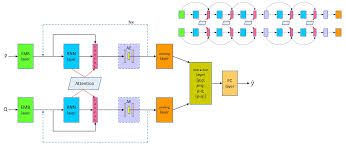





**Preamble**. This file contains the source code for *training* the model. The project is to take Kim et al.'s model that achieves 88.9% accuracy on the Stanford NLI test set. The architecture is displayed above. The experiment is to replace the cosine attention function in the network with multiple attention functions (combinations of cosine, concat, dot, minus, and bilinear), aggregated with a BiLSTM, whose output is fed back into the rest of the architecture.

&nbsp;

The full citation for the DRCN: Kim, Seonhoon, Inho Kang, and Nojun Kwak. 2018. “Semantic Sentence Matching with Densely-Connected Recurrent and Co-Attentive Information.” https://doi.org/arXiv:1805.11360v2.

&nbsp;

The structure of the script is as follows. The first section merely prints start time of the notebook, since the virtual machine on Colab runs on 12 hours maximum cycles; this serves as a reference when the notebook is run. The second 'Options' section allows the specification of the architecture structure in the options list, along with other parameters. The third 'Import Dependencies' section import the relevant packages and connect Google Drive. The fourth 'Setting up data' section reads in SNLI dataset, builds vocabs from GloVe, and prepares the data to be passed to the model through a batch wrapper. The fifth 'prep model' section defines the attention functions and the full DRCN model. The sixth 'Run Model' section loads in any previously trained model for the given options, and then trains the model. Finally, the seventh 'Visualise attention' section then visualises the outputs of the attention functions at different points in the DRCN model.

# Print start time of notebook. Colab 12 hour countdown begins

In [1]:
import datetime
print('Notebook start time: {}'.format(datetime.datetime.now().strftime("%d/%m/%Y, %H:%M:%S")))

Notebook start time: 13/03/2019, 09:19:52


# Options

The following cell dictates the options of the script to be run. The options list may contain any combination of 5 attention functions 'cosine', 'bilinear', 'dot', 'concat', 'minus'. Order does not matter. The cell also automatically generates a unique save file name for the model specified. The script also sends email notifications when each epoch training is complete. The receiver may be specified in receiver_email, and can be a list of email addresses if multiple recipientss are desired. Batch size is 64 by default (not larger due to memory issues). Epochs to run can be specified and training may be forced to restart with the restart_training flag.

In [2]:
# The attention functions to run. Must be a list
options = ['cosine', 'concat', 'minus', 'bilinear']
options = sorted(options) # alphabetical sorting

# receiver email for notification when training is done
receiver_email = "hubertdhwau@gmail.com"

# Set file path for any model to be loaded and/or saved. If no model is detected, training
# will start from stratch. This is determined with a unique naming scheme.
# D -> Dot
# Cs -> Cosine
# Ca -> Concat
# B -> Bilinear
# M -> Minus
attent_name = []
name_dict = {'cosine': 'Cs', 'concat': 'Ca', 'bilinear': 'B', 'minus': 'M', 'dot': 'D'}
for i in options:
  attent_name.append(name_dict[i])
attent_name = sorted(attent_name)
file_path = '/content/gdrive/My Drive/NLP_Project/DRCN-' + '-'.join(attent_name) + '.pt'
print('File path is: {}'.format(file_path))

# Batch size for training. Default 128.
batch_size = 64

# Set number of epochs to run. Default set to 2 since each epoch takes
# ~4 hours to train, allowing 2 epochs per Colab cycle.
epochs_to_run = 2

# Whether to restart training, even if file is found:
restart_training = False

File path is: /content/gdrive/My Drive/NLP_Project/DRCN-Cs.pt


# Import dependencies and set up file path

Import dependencies and connects Google Drive. An authentication code needs to be provided for the connection to Google Drive.

In [3]:
!pip install pytorch-nlp

import numpy as np
import time
import math
import gc
import pickle
from pathlib import Path
import torch
import torchnlp
import torchtext
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm as tq
import itertools
from collections import Counter
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()
porter=PorterStemmer()

import smtplib, ssl

    100% |████████████████████████████████| 92kB 7.8MB/s 
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [4]:
# Connect Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Setting up data

## Define fields and read in SNLI data

The data fields are to be processed as follows. The 'text' field reads in sentences tokenised with words. The 'text_char' field reads in sentences broken down into characters of words. The 'text_stem' and 'text_lemm' fields read in the data at the word level as well, but replacing each word with its stem and lemma, respectively.

In [0]:
def lemmit(sentence):
  
  return [wordnet_lemmatizer.lemmatize(i, pos = 'n') for i in sentence]

def stemmer(sentence):
  
  return [porter.stem(i) for i in sentence]

def splitter(sentence):
  
  # expand each word into its characters
  split_list = [list(i) for i in sentence]

  # join list of lists
  split_list = list(itertools.chain.from_iterable(split_list))
  
  return split_list

In [0]:
# For torchtext before we create a dataset object we need to tell it how to process each data field we feed into it. 
text = torchtext.data.Field(sequential = True, tokenize = 'spacy', batch_first = True, lower = True)
text_char = torchtext.data.Field(sequential = True, tokenize = 'spacy', lower = True, batch_first = True, preprocessing = splitter)
text_stem = torchtext.data.Field(sequential = True, tokenize = 'spacy', lower = True, batch_first = True, preprocessing = stemmer)
text_lemm = torchtext.data.Field(sequential = True, tokenize = 'spacy', lower = True, batch_first = True, preprocessing = lemmit)


# label has sequential = False since the labels are just single words.
label = torchtext.data.Field(sequential=False)

# define fields dict to pass into dataset call to follow.
fields = {'gold_label': ('label',label),
               'sentence1': ('P',text),
               'sentence1_char': ('P_char', text_char),
               'sentence1_stem': ('P_stem', text_stem),
               'sentence1_lemm': ('P_lemm', text_lemm),
               'sentence2': ('Q',text),
               'sentence2_char': ('Q_char', text_char),
               'sentence2_stem': ('Q_stem', text_stem),
               'sentence2_lemm': ('Q_lemm', text_lemm)}

# torchtext 'filter_pred' option only includes examples for which the function is true. Use this to exclude no golden label
train, dev, test = torchtext.data.TabularDataset.splits(path = '/content/gdrive/My Drive/NLP_Project/snli_1.0',
                                     train = 'snli_1.0_train1.tsv',
                                     validation = 'snli_1.0_dev1.tsv',
                                     test = 'snli_1.0_test1.tsv',
                                     format = 'tsv',
                                     skip_header = False,
                                     fields = fields,
                                     filter_pred = lambda example: example.label != '-')

## Build vocabs

The following cell loads in the GloVe vectors.

In [7]:
torch.manual_seed(1)
torch.cuda.manual_seed(1)

text.build_vocab(train, dev, test, vectors = 'glove.840B.300d', unk_init = torch.nn.init.normal_)
text_char.build_vocab(train, dev, test)
text_stem.build_vocab(train, dev, test)
text_lemm.build_vocab(train, dev, test)
label.build_vocab(train, dev, test)

# give padding zero index again 
text.vocab.vectors[1] = torch.zeros(300)

.vector_cache/glove.840B.300d.zip: 2.18GB [03:43, 9.76MB/s]                            
100%|█████████▉| 2195673/2196017 [05:12<00:00, 7686.94it/s]

## Create trainable vocab that is initialised as a copy of GloVe

In [0]:
# create another vocab option that will store the trained word embeddings, initialised on GloVe
trainable_vocab = torchtext.vocab.Vocab(text.vocab.freqs, specials = ['<unk>','<pad>'])
trainable_vocab.set_vectors(text.vocab.stoi, text.vocab.vectors, dim = 300)

## Create train, dev, test splits - batch size and shuffle

In [0]:
# split train, dev, and test set into iterators. shuffle = True to shuffle examples between epochs.
train_iter, dev_iter, test_iter = torchtext.data.BucketIterator.splits((train, dev, test),
                                                                       batch_size = batch_size,
                                                                       sort_key = lambda x: -len(x.P),
                                                                       shuffle = False)

## Preparing the data: batch wrapper

The batch wrapper class takes in the examples from the dataset and preprocesses them as necessary for the model. In particular, the batch wrapper calculates the exact match flag, which is activated whenever **either** the stem or the lemma of a word is present in the other sentence.

In [0]:
# Create batch wrapper to return the correct input for the DRCN model:

class BatchWrapper:
  def __init__(self, iterator):
    self.iterator = iterator

  def __iter__(self):
    for batch in self.iterator:
      
      # retrieve objects from iterator
      P = getattr(batch, 'P')
      P_char = getattr(batch, 'P_char')
      P_stem = getattr(batch, 'P_stem')
      P_lemm = getattr(batch, 'P_lemm')
      
      Q = getattr(batch, 'Q')
      Q_char = getattr(batch, 'Q_char')
      Q_stem = getattr(batch, 'Q_stem')
      Q_lemm = getattr(batch, 'Q_lemm')
      
      labels = getattr(batch, 'label')      
      
      # ensure P and Q are fixed:
      P.requires_grad_(requires_grad=False)
      Q.requires_grad_(requires_grad=False)
      
      # detect exact match binary flag
      match_matrix_P_stem = torch.zeros(P.shape[0], P_stem.shape[1])
      match_matrix_P_lemm = torch.zeros(P.shape[0], P_lemm.shape[1])
      
      match_matrix_Q_stem = torch.zeros(Q.shape[0], Q_stem.shape[1])
      match_matrix_Q_lemm = torch.zeros(Q.shape[0], Q_lemm.shape[1])
      
      for ind in range(P.shape[0]):
        
        sen_p_stem = P_stem[ind, :]
        sen_p_lemm = P_lemm[ind, :]
        
        sen_q_stem = Q_stem[ind, :]
        sen_q_lemm = Q_lemm[ind, :]
        
        #remove padding
        sen_p_stem = [i for i in sen_p_stem if (i != 1)]
        sen_p_lemm = [i for i in sen_p_lemm if (i != 1)]
        
        sen_q_stem = [i for i in sen_q_stem if (i != 1)]
        sen_q_lemm = [i for i in sen_q_lemm if (i != 1)]
        
        # find intersecting elements
        intersection_stem = np.intersect1d(np.asarray(sen_p_stem), np.asarray(sen_q_stem))
        intersection_lemm = np.intersect1d(np.asarray(sen_p_lemm), np.asarray(sen_q_lemm))

        # for each intersecting element, turn the corresponding item in match_matrix to True
        for shared_element in intersection_stem:
          match_matrix_P_stem[ind, np.argwhere(sen_p_stem==shared_element)] = 1
          match_matrix_Q_stem[ind, np.argwhere(sen_q_stem==shared_element)] = 1

        for shared_element in intersection_lemm:
          match_matrix_P_lemm[ind, np.argwhere(sen_p_lemm==shared_element)] = 1
          match_matrix_Q_lemm[ind, np.argwhere(sen_q_lemm==shared_element)] = 1
          
      # combine the match matrices, expressing OR logical operation mathematically    
      match_matrix_P = match_matrix_P_stem + match_matrix_P_lemm - torch.mul(match_matrix_P_stem, match_matrix_P_lemm)
      match_matrix_Q = match_matrix_Q_stem + match_matrix_Q_lemm - torch.mul(match_matrix_Q_stem, match_matrix_Q_lemm)
      
      # reduce label by 1 so it's index-friendly
      labels = labels - 1
      
      yield (P.cuda(), P_char.cuda(), Q.cuda(), Q_char.cuda(), match_matrix_P.cuda(), match_matrix_Q.cuda(), labels.cuda())

  def __len__(self):
    return len(self.iterator)

train_data = BatchWrapper(train_iter)
dev_data = BatchWrapper(dev_iter)
test_data = BatchWrapper(test_iter)

# Prepare model

## Define index_to_word_length to be used in character convolutions

In [0]:
# Define function to extract relevant character embeddings:
index_to_word_length = Counter()
for key, value in text.vocab.stoi.items():
  index_to_word_length[value] = len(key)

## Define Attention Functions

Define the attention functions to be used in the DRCN model. This is adapted from the torchnlp source code available at https://pytorchnlp.readthedocs.io/en/latest/_modules/torchnlp/nn/attention.html

In [0]:
class MultiAttention(nn.Module):
  """ Applies attention mechanism on the `context` using the `query`.

  Modified source code retrieved from torchnlp package.
  https://pytorchnlp.readthedocs.io/en/latest/_modules/torchnlp/nn/attention.html

  Args:
      dimensions (int): Dimensionality of the query and context.
      options (list): input list of declared attention functions you want

  Example:

       >>> attention = Attention(256)
       >>> query = torch.randn(5, 1, 256)
       >>> context = torch.randn(5, 5, 256)
       >>> output, weights = attention(query, context)
       >>> output.size()
       torch.Size([5, 1, 256])
       >>> weights.size()
       torch.Size([5, 1, 5])
  """

  def __init__(self, dimensions, options):
    super(MultiAttention, self).__init__()
        
    if not(set(options).issubset({'dot','bilinear','cosine','concat','minus'})):
      raise ValueError('Invalid attention type selected.')
    elif len(set(options))<len(options):
      raise Syntaxerror('Duplicate attention options specified')
    else:
      self.options = options
    
    # Create linear layers for the relevant options declared:
    if 'bilinear' in self.options:
      self.linear_bi = nn.Linear(dimensions, dimensions, bias=False)
    
    if 'dot' in self.options:
      self.linear_dot = nn.Linear(dimensions, dimensions, bias=False)
      self.linear_dot_out = nn.Linear(dimensions, 1, bias=False)
      
    if 'concat' in self.options:
      self.linear_cat_in = nn.Linear(2*dimensions, 2*dimensions, bias = False)
      self.linear_cat_out = nn.Linear(2*dimensions, 1, bias = False)
    
    if 'minus' in self.options:
      self.linear_minus = nn.Linear(dimensions, dimensions, bias = False)
      self.linear_minus_out = nn.Linear(dimensions, 1, bias = False)
    
    self.multiway = len(options)>1
    
    if self.multiway:
      self.lstm_agg = nn.LSTM(len(options)*dimensions, int(dimensions/2), bidirectional = True, batch_first = True)
    
    self.softmax = nn.Softmax(dim=-1)
    
    self.tanh = nn.Tanh()

  def forward(self, query, context):
    """
    Args:
        query (:class:`torch.FloatTensor` [batch size, output length, dimensions]): Sequence of
            queries to query the context.
        context (:class:`torch.FloatTensor` [batch size, query length, dimensions]): Data
            overwhich to apply the attention mechanism.

    Returns:
        :class:`tuple` with `output` and `weights`:
        * **output** (:class:`torch.LongTensor` [batch size, output length, dimensions]):
          Tensor containing the attended features.
        * **weights** (:class:`torch.FloatTensor` [batch size, output length, query length]):
          Tensor containing attention weights.
    """
    
    batch_size, output_len, dimensions = query.size()
    query_len = context.size(1)

    '''
    ####################################### Calculate multiway attention ##################################
    '''
    
    # initialise list to score attention scores and weights
    output = []
    attention_weights = []
    
    for i in self.options:
      
      if i == 'cosine':
        
        # calculate L2 norm to divide for cosine similarity.
        # (batch_size, query/context length, dimensions) -> (batch_size, query/context length) 
        p_lengths = torch.norm(query, dim=2)
        q_lengths = torch.norm(context, dim=2)

        divisor = torch.einsum('ij, ik -> ijk', p_lengths, q_lengths)
        divisor = torch.max(divisor, torch.zeros(divisor.size()).cuda()+1e-8) # avoid division by zero

        # dot product
        # (batch_size, output_len, dimensions) * (batch_size, query_len, dimensions) ->
        # (batch_size, output_len, query_len)
        attent_scores = torch.bmm(query, context.transpose(1, 2).contiguous())
        attent_scores = torch.div(attent_scores, divisor)

        # Compute weights across every context sequence
        attent_scores = attent_scores.view(batch_size * output_len, query_len)
        attent_weights = self.softmax(attent_scores)
        attent_weights = attent_weights.view(batch_size, output_len, query_len)

        # (batch_size, output_len, query_len) * (batch_size, query_len, dimensions) ->
        # (batch_size, output_len, dimensions)
        out = torch.bmm(attent_weights, context)
        
        del attent_scores
        
        output.append(out)
        attention_weights.append(attent_weights.detach())
        

      if i == 'concat':
        
        # compute concat through linear layer
        attent_scores = torch.cat((query.unsqueeze(2).expand(-1,-1,query_len,-1),
                                  context.unsqueeze(1).expand(-1,output_len,-1,-1)), dim = 3)
        attent_scores = attent_scores.view(batch_size * output_len * query_len, 2*dimensions)
        attent_scores = self.linear_cat_in(attent_scores)
        
        # apply nonlinearity and push through linear_out layer
        attent_scores = self.tanh(attent_scores)
        attent_scores = self.linear_cat_out(attent_scores).squeeze()
       
        # apply softmax
        attent_scores = attent_scores.view(batch_size * output_len, query_len)
        attent_weights = self.softmax(attent_scores)
        attent_weights = attent_weights.view(batch_size, output_len, query_len)
        
        # calculate output. (batch_size, output_len, dimensions)
        out = torch.bmm(attent_weights, context)
        
        del attent_scores
        
        output.append(out)
        attention_weights.append(attent_weights.detach())
        
      
      if i == 'bilinear':
        
        # compute bilinear outputs
        query_bi = query.clone()
        query_bi = query_bi.contiguous().view(batch_size * output_len, dimensions)
        query_bi = self.linear_bi(query_bi)
        query_bi = query_bi.view(batch_size, output_len, dimensions)
        
        # multiply by context and take softmax
        attent_scores = (torch.bmm(query_bi, context.transpose(1, 2).contiguous()))
        attent_scores = attent_scores.view(batch_size * output_len, query_len)
        attent_weights = self.softmax(attent_scores)
        attent_weights = attent_weights.view(batch_size, output_len, query_len)
        
        # calculate output. (batch_size, output_len, dimensions)
        out = torch.bmm(attent_weights, context)
        
        del attent_scores
        
        output.append(out)
        attention_weights.append(attent_weights.detach())

      
      if i == 'dot':
        
        # compute elementwise multiplication over dimensions
        # output (batch_size, output_len, query_len, dimensions)
        attent_scores = torch.einsum('ijk, ilk -> ijlk', [query, context])
        
        # feed through linear layers
        attent_scores = attent_scores.contiguous().view(batch_size * output_len * query_len, dimensions)
        attent_scores = self.linear_dot(attent_scores)
        attent_scores = self.tanh(attent_scores)
        attent_scores = self.linear_dot_out(attent_scores).squeeze()
        
        # apply softmax
        attent_scores = attent_scores.view(batch_size * output_len, query_len)
        attent_weights = self.softmax(attent_scores)
        attent_weights = attent_weights.view(batch_size, output_len, query_len)
        
        # calculate output. (batch_size, output_len, dimensions)
        out = torch.bmm(attent_weights, context)
        
        del attent_scores
        
        output.append(out)
        attention_weights.append(attent_weights.detach())
        
      
      if i == 'minus':
      
        # compute subtraction and linear pass
        attent_scores = query.unsqueeze(2).expand(-1,-1,query_len,-1) - context.unsqueeze(1).expand(-1,output_len,-1,-1)
        attent_scores = attent_scores.contiguous().view(batch_size * output_len * query_len, dimensions)
        attent_scores = self.linear_minus(attent_scores)
        
        # apply nonlinearity and push through linear_out layer
        attent_scores = self.tanh(attent_scores)
        attent_scores = self.linear_minus_out(attent_scores).squeeze()
       
        # apply softmax
        attent_scores = attent_scores.view(batch_size * output_len, query_len)
        attent_weights = self.softmax(attent_scores)
        attent_weights = attent_weights.view(batch_size, output_len, query_len)
        
        # calculate output. (batch_size, output_len, dimensions)
        out = torch.bmm(attent_weights, context)
        
        del attent_scores
        
        output.append(out)
        attention_weights.append(attent_weights.detach())
        
        
        
    
    '''
    ####################################### Aggregate multiway attention ##################################
    '''
    if self.multiway:
      
      # concatenate outputs:
      collated = torch.empty(0).cuda()
      
      for i in output:
        collated = torch.cat((collated, i), dim = 2)
      
      output, _ = self.lstm_agg(collated)
    
    else:
      
      output = output[0]
      attention_weights = attention_weights[0]
    
    

    return output, attention_weights

## Define Model

Defines the DRCN model.

In [13]:
class DRCN(nn.Module):
  
  def __init__(self, hidden_dim, batch_size, options, emb_dim=300):
    super().__init__() # don't forget to call this!

    self.batch_size = batch_size
    
    self.hidden = hidden_dim
    
    # fixed embeddings. (batch_size, max_sentence_length) -> (batch_size, max_sentence_length, embed_size=300)
    self.embedding = nn.Embedding.from_pretrained(text.vocab.vectors, freeze = True)

    # trainable embeddings. (batch_size, max_sentence_length) -> (batch_size, max_sentence_length, embed_size=300)
    self.embedding_train = nn.Embedding.from_pretrained(trainable_vocab.vectors, freeze = False)

    # character embeddings. (batch_size, max_sentence_char_length) -> (batch_size,  max_sentence_char_length, embed_size=16)
    self.embedding_char = nn.Embedding(len(text_char.vocab), 16, padding_idx = 1)

    # character convolutional layer, ReLU activation. (N, C_in, H_in, W_in) -> (N, C_out, H_out, W_out)
    self.char_cnn = nn.Sequential(nn.Conv2d(1, 32, kernel_size = (2,16), padding = (1,0)),nn.ReLU())

    # attention
    self.attent = MultiAttention(200, options)
    self.attent_stack = MultiAttention(100, options)
    
    # dropout
    self.dropout_1 = nn.Dropout(p=0.5)
    self.dropout_2 = nn.Dropout(p=0.2)
    
    # first layer of RNN stack
    self.base_LSTM = nn.LSTM(2*emb_dim+33, hidden_dim, num_layers=1, bidirectional = True, batch_first = True)
    
    # define further layers of RNN stack
    self.RNN_stack = nn.ModuleList([nn.RNN(4*hidden_dim, hidden_dim, num_layers = 1, batch_first = True),
                                   nn.RNN(6*hidden_dim, hidden_dim, num_layers = 1, batch_first = True),
                                   nn.RNN(8*hidden_dim, hidden_dim, num_layers = 1, batch_first = True),
                                   nn.RNN(10*hidden_dim, hidden_dim, num_layers = 1, batch_first = True)])
    # define final layers
    self.linear_layers = nn.ModuleList([nn.Sequential(nn.Linear(6000,1000),nn.ReLU(),nn.BatchNorm1d(1000)),
                                       nn.Sequential(nn.Linear(1000,1000),nn.ReLU(),nn.BatchNorm1d(1000))])

    self.softmax = nn.LogSoftmax(dim=1)

    self.predictor = nn.Linear(1000, 3)

  def character_representation(self, seq, seq_char):
  
    '''
    define function to take in batch size and words to produce character representations
    '''
  
    # (batch size, number of words, 32d character representation)
    char_embed_output = torch.zeros(seq.shape[0], seq.shape[1], 32)
    
    # place tensor on GPU
    char_embed_output = char_embed_output.cuda()
    
    # output (batch size, max characters in a sentence, 16d random character representation)
    char_embed_layer = self.embedding_char(seq_char) 

    # run over sentences in the batch. seq has shape (batch size, max_sentence_length)
    for s in range(seq.shape[0]):
      
      # initialise counter variable to determine where in the char_embed_layer output to extract
      # the relevant characters constituent to a word
      count = 0
      
      # now loop over each sentence
      for index, word_index in enumerate(seq[s,:]):

        # conditionalise on whether the character is a padding index. If so, just return zeros (see else statement)
        if word_index.item() != 1:
          
          # retrieve length of word
          end = index_to_word_length[word_index.item()]

          ## extract character embeddings for this word.
          
          # output (letters in word, character representation size = 16)
          input_to_conv = char_embed_layer[s, count:count+end, :]
          
          # output (1, letters_in_word, character representation size = 16)
          input_to_conv = torch.unsqueeze(input_to_conv,0)
          
          # output (1, 1, letters_in_word, character representation size = 16)
          input_to_conv = torch.unsqueeze(input_to_conv,0)

          # input through convolutional layer
          temp = self.char_cnn(input_to_conv)
          
          # remove trailing dimensions
          temp = torch.squeeze(temp)
          
          # if there was more than one character there is one more non-singleton dimension
          # to maxpool over.
          if temp.dim() != 1:
            temp, _ = torch.max(temp, dim = 1)
          
          # assign output to char_embed_output
          char_embed_output[s, index, :] = temp

          # increase count
          count += end

        if word_index.item() == 1:
          
          # set padding embedding to zeros
          char_embed_output[s, index, :] = torch.zeros(32)

    return char_embed_output

  def forward(self, batch_dat):
    
    # extract data from batch
    P, P_char, Q, Q_char, match_P, match_Q, labels = batch_dat

    '''
    #########################################################################################################################
    #
    # Word Representation Layer
    #
    #########################################################################################################################
    '''
    
    char_rep_p = self.character_representation(P, P_char)
    char_rep_q = self.character_representation(Q, Q_char)
    
    '''
    ##################################### END OF WORD REPRESNTATION LAYER. ##################################################
    '''
    
    '''
    #########################################################################################################################
    #
    # RNN Stack
    #
    #########################################################################################################################
    '''

    # concatenate all relevant parts. This line is the end of the representation layer.        
    hdn_p, _ = self.base_LSTM(torch.cat((self.embedding(P),
                                     self.embedding_train(P),
                                     char_rep_p,
                                     match_P.unsqueeze(2)), dim = 2))
    
    # output (batch_size, max_sentence_length, 2*hidden_dim)
    hdn_q, _ = self.base_LSTM(torch.cat((self.embedding(Q),
                                 self.embedding_train(Q),
                                 char_rep_q,
                                 match_Q.unsqueeze(2)), dim = 2))
    
    # apply dropout
    hdn_p = self.dropout_1(hdn_p)
    hdn_q = self.dropout_1(hdn_q)
        
    # compute attention at this point. Co-attention means p on q and q on p.
    a_p_on_q, pq_weight = self.attent(hdn_p, hdn_q)
    a_q_on_p, qp_weight = self.attent(hdn_q, hdn_p)

    
    #layer_outputs = [[torch.cat((hdn_p,a_p_on_q), dim=2)], [torch.cat((hdn_q, a_q_on_p),dim=2)]]
    layer_outputs = [torch.cat((hdn_p, a_p_on_q), dim=2),
                     torch.cat((hdn_q, a_q_on_p), dim=2)]
    
    # initialise object that can be returned for attention visualisation
    attent_to_return = [[pq_weight],[qp_weight]]
    
    for i, layer in enumerate(self.RNN_stack):
      
      # compute RNN output for this layer
      p_output, _ = layer(layer_outputs[0])
      q_output, _ = layer(layer_outputs[1])
      
      # apply dropout
      p_output = self.dropout_1(p_output)
      q_output = self.dropout_1(q_output)
      
      # compute attention
      att_p_on_q, pq_weight = self.attent_stack(p_output, q_output)
      att_q_on_p, qp_weight = self.attent_stack(q_output, p_output)
    
      # append for visualisation
      attent_to_return[0].append(pq_weight)
      attent_to_return[1].append(qp_weight)
      
      # append to output for next layer
      layer_outputs[0] = torch.cat((layer_outputs[0],p_output,att_p_on_q), dim = 2)
      layer_outputs[1] = torch.cat((layer_outputs[1],q_output,att_q_on_p), dim = 2)
    
    '''
    ##################################### END RNN ###########################################################################
    '''
    
    '''
    #########################################################################################################################
    #
    # Pooling Layer
    #
    #########################################################################################################################
    '''
    
    p_pool, _ = torch.max(layer_outputs[0], dim = 1)
    q_pool, _ = torch.max(layer_outputs[1], dim = 1)
      
    '''
    ##################################### END POOLING #######################################################################
    '''
    
    '''
    #########################################################################################################################
    #
    # Interaction and Prediction Layer
    #
    #########################################################################################################################
    '''
    
    feature = torch.cat((p_pool, q_pool, p_pool+q_pool, p_pool-q_pool, torch.abs(p_pool-q_pool)), dim = 1)
    feature = self.dropout_2(feature)
    
    # feed into fully connected layers
    for layer in self.linear_layers:
      feature = layer(feature)
       
    output = self.predictor(feature)

    '''
    ##################################### END INTERACTION AND PREDICTION LAYER ##############################################
    '''
    
    return self.softmax(output), attent_to_return

nh = 100
model = DRCN(nh, batch_size, options)

model.cuda()

DRCN(
  (embedding): Embedding(34185, 300)
  (embedding_train): Embedding(34185, 300)
  (embedding_char): Embedding(64, 16, padding_idx=1)
  (char_cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(2, 16), stride=(1, 1), padding=(1, 0))
    (1): ReLU()
  )
  (attent): MultiAttention(
    (softmax): Softmax()
    (tanh): Tanh()
  )
  (attent_stack): MultiAttention(
    (softmax): Softmax()
    (tanh): Tanh()
  )
  (dropout_1): Dropout(p=0.5)
  (dropout_2): Dropout(p=0.2)
  (base_LSTM): LSTM(633, 100, batch_first=True, bidirectional=True)
  (RNN_stack): ModuleList(
    (0): RNN(400, 100, batch_first=True)
    (1): RNN(600, 100, batch_first=True)
    (2): RNN(800, 100, batch_first=True)
    (3): RNN(1000, 100, batch_first=True)
  )
  (linear_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=6000, out_features=1000, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
  

# Run Model

## Define optimiser and load in any previously trained models

In [14]:
# Load in model as it is so far

# define optimiser. 'All weights except embedding matrices are constrained by L2 regularization with a regularization
# constant lambda = 1e-6'
opt= optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-6)

# add learning rate decay when dev accuracy stops increasing
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode = 'max', factor = 0.15, verbose = True)

model_file = Path(file_path)

if model_file.is_file() and not(restart_training):
  
  checkpoint = torch.load(file_path)
  model.load_state_dict(checkpoint['model_state_dict'])
  best_model = checkpoint['best_model']
  opt.load_state_dict(checkpoint['optimizer_state_dict'])
  scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
  batch_to_save = checkpoint['returned_attention']
  start_epoch = checkpoint['epoch']
  best_epoch = checkpoint['best_epoch']
  train_losses = checkpoint['train_losses']
  dev_losses = checkpoint['dev_losses']
  dev_scores = checkpoint['dev_scores']
  test_scores = checkpoint['test_scores']
  attention_funcs = checkpoint['attention_funcs']
  
  print('Model detected and loaded. Number of epochs trained: {:d}.'.format(start_epoch))
  print('Attention functions: {}'.format(attention_funcs))
  print('Last epoch dev accuracy: {:.4f}'.format(dev_scores[-1]))
  
  if attention_funcs != options:
    print('WARNING: different attention function options detected')
  
else:
  
  start_epoch = 0
  dev_scores = []
  dev_losses = []
  test_scores = []
  train_losses = []
  print('No model detected, starting training at epoch 0')


Model detected and loaded. Number of epochs trained: 6.
Attention functions: ['cosine']
Last epoch dev accuracy: 0.7820


## Perform training

In [0]:
torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False
torch.cuda.empty_cache()

# Define loss function. NLL + softmax is multi class cross entropy loss
loss_func = nn.NLLLoss()

# generate random number for batch attention extraction
batch_rand = np.random.randint(0,math.ceil(len(dev)/batch_size))

# setup for email notifications
port = 465  # For SSL
password = 'googlecolab'
smtp_server = "smtp.gmail.com"
sender_email = "hube.colab.notifier@gmail.com"

# Create a secure SSL context
context = ssl.create_default_context()

for current_epoch in tq(range(start_epoch + 1, start_epoch + 1 + epochs_to_run), desc = 'Epochs'):
    
    print('Current Epoch is {}'.format(current_epoch))
    
    '''
    #########################################################################################################################
    #
    # Perform training
    #
    #########################################################################################################################
    '''
  
    # initialise
    running_loss = 0.0
    running_corrects = 0
    
    # turn on training mode
    model.train() 
    
    for i, batch_data in enumerate(tq(train_data, desc='Training', total = math.ceil(len(train)/batch_size), leave = False)):
      
        labels = batch_data[-1]
        
        opt.zero_grad()
        
        pred, _ = model(batch_data)

        loss = loss_func(pred, labels)
        loss.backward()
        opt.step()
         
        running_loss += float(loss.item()) * batch_size
  
    epoch_loss = running_loss/len(train)
    train_losses.append(epoch_loss)
    
    torch.cuda.empty_cache()
    
    '''
    #########################################################################################################################
    #
    # Calculate dev set metrics
    #
    #########################################################################################################################
    '''
    
    # calculate the validation loss for this epoch
    val_loss = 0.0
    model.eval() # turn on evaluation mode
    val_preds = torch.zeros(1, dtype=torch.float64).cuda()
    
    with torch.no_grad():
      for i, batch_data in enumerate(tq(dev_data, desc = 'Dev Eval', total = math.ceil(len(dev)/batch_size), leave = False)):

          labels = batch_data[-1]

          pred, attention_returned = model(batch_data)

          v_loss = loss_func(pred, labels)
          val_loss += v_loss.item() * batch_size

          check = torch.argmax(pred, dim = 1)==batch_data[-1]
          
          val_preds += check.float().sum().item()

          torch.cuda.empty_cache()
          
          # save random batch for attention visualisation
          if i == int(batch_rand):
            if current_epoch == 1:
              batch_to_save = [batch_data[0], batch_data[2], attention_returned, labels]
            elif current_epoch > 1:
              temp_batch_to_save = [batch_data[0], batch_data[2], attention_returned, labels]
 
    # calculate loss and accuracy
    val_loss /= len(dev)
    
    accuracy = val_preds.item()/len(dev)
    
    # save best model. If current_epoch > 1 and it is not the best, still saves values for epoch 1.
    if current_epoch == 1:
      best_epoch = 1
      best_model = model.state_dict()
      
    elif val_loss <= min(dev_losses):
      best_epoch = current_epoch
      best_model = model.state_dict().copy()
      batch_to_save = temp_batch_to_save
    
    else:
      pass
    
    # save values
    dev_scores.append(accuracy)
    dev_losses.append(val_loss)
    scheduler.step(accuracy)

      
    torch.cuda.empty_cache()
    
    '''
    #########################################################################################################################
    #
    # Calculate test predictions
    #
    #########################################################################################################################
    '''
    
    # calculate test predictions
    test_preds = torch.zeros(1, dtype=torch.float64).cuda()
    
    with torch.no_grad():
      for x in tq(test_data, desc = 'Test Eval', total = math.ceil(len(test)/batch_size)):
        
          pred, test_attentions = model(x)
          
          pred = torch.argmax(pred, dim = 1)
          
          check = pred==x[-1]
          
          test_preds += check.float().sum().item()
          
          torch.cuda.empty_cache()
        
    # calculate accuracy
    test_acc = test_preds.item()/len(test)
    
    # save scores
    test_scores.append(test_acc)
    
    torch.cuda.empty_cache()

    '''
    #########################################################################################################################
    #
    # Save model
    #
    #########################################################################################################################
    '''
    
    # save current progress
    torch.save({
          'epoch': current_epoch,
          'dev_scores': dev_scores,
          'train_losses': train_losses,
          'dev_losses': dev_losses,
          'test_scores': test_scores,
          'attention_funcs': options,
          'best_epoch': best_epoch,
          'returned_attention': batch_to_save,
          'model_state_dict': model.state_dict(),
          'best_model': best_model,
          'optimizer_state_dict': opt.state_dict(),
          'scheduler_state_dict': scheduler.state_dict()
          }, file_path)
    
    '''
    #########################################################################################################################
    #
    # Send email notification
    #
    #########################################################################################################################
    '''
    
    message = """Subject: Epoch {} complete; model {}\n\n
    train_loss = {:.4f}, dev_loss = {:.4f}
    d_acc = {:.4f}, test_acc = {:.4f}
    """.format(current_epoch, '-'.join(attent_name), epoch_loss, val_loss, accuracy, test_acc)

    # Send email notification
    with smtplib.SMTP_SSL("smtp.gmail.com", port, context=context) as server:
      server.login(sender_email, password)
      server.sendmail(sender_email, receiver_email, message)
    
    '''
    #########################################################################################################################
    #
    # Print desired outputs
    #
    #########################################################################################################################
    '''
    
    print('model saved at {}'.format(datetime.datetime.now().strftime("%d/%m/%Y, %H:%M:%S")))
    
    print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}'.format(current_epoch, epoch_loss, val_loss, accuracy))
    print('Test set accuracy: {:.4f}'.format(test_acc))
    
    

Current Epoch is 5


model saved at 09/03/2019, 12:45:12
Epoch: 5, Training Loss: 0.4164, Validation Loss: 2.5968, Validation Accuracy: 0.6559
Test set accuracy: 0.6534
Current Epoch is 6


model saved at 09/03/2019, 17:44:02
Epoch: 6, Training Loss: 0.4024, Validation Loss: 1.4786, Validation Accuracy: 0.7709
Test set accuracy: 0.7666



Exception ignored in: <bound method tqdm.__del__ of 100%|█████████▉| 2195839/2196017 [10:05:50<00:00, 7517.67it/s]>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 931, in __del__
    self.close()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 1133, in close
    self._decr_instances(self)
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 496, in _decr_instances
    cls.monitor.exit()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py", line 52, in exit
    self.join()
  File "/usr/lib/python3.6/threading.py", line 1053, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread


In [32]:
loss_func = nn.NLLLoss()
val_loss = 0.0
model.eval() # turn on evaluation mode
val_preds = torch.zeros(1, dtype=torch.float64).cuda()

batch_rand = np.random.randint(0,math.ceil(len(dev)/batch_size))

with torch.no_grad():
    for i, batch_data in enumerate(tqdm(dev_data, desc = 'Dev Eval', total = math.ceil(len(dev)/batch_size), leave = False)):

        labels = batch_data[-1]

        pred, attention_returned = model(batch_data)

        v_loss = loss_func(pred, labels)
        val_loss += v_loss.item() * batch_size

        check = torch.argmax(pred, dim = 1)==batch_data[-1]

        val_preds += check.float().sum().item()

        # save random batch for attention visualisation
        if i == int(batch_rand):
          batch_to_save = [batch_data[0], batch_data[2], attention_returned, torch.argmax(pred, dim = 1), labels]



Exception ignored in: <bound method tqdm.__del__ of Dev Eval:   3%|▎         | 4/154 [02:03<04:17,  1.71s/it]>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 931, in __del__
    self.close()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 1133, in close
    self._decr_instances(self)
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 496, in _decr_instances
    cls.monitor.exit()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py", line 52, in exit
    self.join()
  File "/usr/lib/python3.6/threading.py", line 1053, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread


# Visualise attention

This section takes the output from the pervious section and visualises the attention weights from each attention function in the model. Each row contains the outputs from the attention function from layer 1, 3, and 5 going from left to right.


In [0]:
def visualise_attention(saved_batch, sen_num, save = False, cmap = 'viridis', show = False):

  correct = saved_batch[-1]==saved_batch[-2]
  correct_dict={1:'Correctly', 0:'Incorrectly'}
  
  if show:
    plt.ion()
  else:
    plt.ioff()
  
  plt.rcParams["axes.grid"] = False
  
  attent_out = saved_batch[2]
  ans = saved_batch[-1]
  p_len = 0
  p_words = []
  for i in saved_batch[0][sen_num,:]:
    if i != 1:
      p_len += 1
      p_words.append(text.vocab.itos[i])
  q_len = 0
  q_words = []
  for i in saved_batch[1][sen_num,:]:
    if i != 1:
      q_len += 1
      q_words.append(text.vocab.itos[i])
  
  print(p_words)
  print(q_words)
  answer = label.vocab.itos[int(ans[sen_num])+1]
  print(answer)
  
  fig, ax = plt.subplots(len(options),3, figsize = (20,20))
      
  funcs = ['Bilinear', 'Concat', 'Cosine', 'Minus']

  for layer in range(3):
    for i in range(len(options)):

      #[p or q][layer][function][batch_size, p_len, q_len]
      ax[i,layer].imshow(attent_out[0][2*layer][i][sen_num,:p_len,:q_len].cpu().numpy(), cmap = cmap, origin = 'upper')
      ax[i,layer].set_xticks(np.arange(q_len))
      ax[i,layer].set_yticks(np.arange(p_len))
      ax[i,layer].set_xticklabels(q_words)
      ax[i,layer].set_yticklabels(p_words)
      ax[i,layer].tick_params(axis='x', rotation=45)
      if layer == 0:
        ax[i,layer].set_ylabel(funcs[i], rotation = 0, labelpad = 30, fontsize = 14, fontweight = 'bold')
  
  
  fig.suptitle("Visualisation of attention weights. Example of {}. {} predicted by model.".format(answer,correct_dict[correct[sen_num].item()]),
              fontsize=16,
              fontweight = 'bold')
  
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  
  if save:
    string = '/content/gdrive/My Drive/NLP_Project/Graphs/attent-'+'-'.join(attent_name) + '-' + answer + '-' + str(sen_num) + '-qp.eps'
    plt.savefig(string, format = 'eps')

In [0]:
visualise_attention(batch_to_save, 0, save = 0, show = 1)